**Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2021**		

**Лабораторная работа №5. Адаптация и калибровка системы распознавания диктора**

**Цель работы:** изучение методов адаптации и калибровки, используемых на практике при решении задачи голосовой биометрии.

**Краткое описание:** в рамках настоящей лабораторной работы предлагается изучить и реализовать некоторые алгоритмы адаптации и калибровки биометрических систем. В качестве процедуры адаптации предлагается рассмотреть адаптацию на основе s-нормализации. Процедуру калибровки предлагается реализовать с помощью метода логистической регрессии. Тестирование системы голосовой биометрии после выполнения процедур адаптации и калибровки предлагается выполнить на основе метрик равновероятной ошибки и минимума функции стоимости детектирования применительно к задаче верификации.

**Данные:** в качестве данных для выполнения лабораторной работы предлагается использовать тестовую часть базы
[VoxCeleb1](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html) и [VoxCeleb2](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html).

**Содержание лабораторной работы**

1.	Подготовка данных для выполнения процедуры адаптации.  

2.	Реализация процедуры адаптации с использованием s-нормализации.  

3.	Тестирование адаптированной к некоторым условиям биометрической системы.  

4.	Подготовка данных для выполнения процедуры калибровки.  

5.	Реализация простейшего алгоритма для выполнения процедуры калибровки системы голосовой биометрии.  

6.	Тестирование калиброванной системы голосовой биометрии.  

In [1]:
# IPython extension to reload modules before executing user code
%load_ext autoreload
%autoreload 2

# Import of modules
import os
import sys

sys.path.append(os.path.realpath('..'))

import torch
import numpy as np
import itertools

from math import sqrt, pi
from matplotlib.pyplot import hist, plot, show, grid, title, xlabel, ylabel, legend, axis, imshow
from torch.utils.data import DataLoader
from functools import partial
import glob

import common
from common import download_dataset, extract_dataset, download_protocol, run_voxceleb_convert, part_extract
from common import get_voxceleb_filelist
from common import test_dataset_loader
from common import extract_features, compute_scores_cosine
from common import get_eer, get_dcf
from common import concatenate
from common import tsne
from LoadModel import load_model
from ResNetSE34V2 import MainModel

from exercises_blank import plot_histograms_2sets, s_norm, get_tar_imp_scores, train_calibration
from exercises_blank import CalibrationLoss, LinearCalibrationModel, CalibrationDataset, train_calibration
from Optimizer import SGDOptimizer
from Scheduler import StepLRScheduler

**1. Подготовка тестовых данных и протокола для проведения тестирования системы верификации диктора**

В ходе выполнения лабораторной работы необходимы *тестовые данные*, а также связанный с ними *протокол тестирования*. Данные представляют собой звукозаписи голосов людей мужского и женского пола, сохраненных в формат *wav*. Протокол тестирования организован в виде текстового файла, в каждой строчке которого содержится одна таргет- или импостор-попытка сравнения эталонной и тестовой звукозаписи (рассматривается задача *верификации диктора*, т.е. сравнение «один к одному»). Голоса эталона и теста из *таргет-попытки* (метка «1») соответствуют одному и тому же диктору, а голоса эталона и теста из *импостор-попытки* (метка «0») соответствуют разным дикторам.

Необходимые данные можно скачать по ссылкам, представленным ниже. В рамках настоящего пункта требуется:

1. Выполнить загрузку и распаковку звуковых wav-файлов базы [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip) и [VoxCeleb2 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_wav.zip).

2. Преобразовать базу [VoxCeleb2 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_wav.zip) из aac-формата в wav-формат.

3. Выполнить загрузку протокола тестирования [VoxCeleb1-O cleaned](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/meta/veri_test2.txt).

4. Подготовить тестовые и адаптационные данные путём применения к оригинальным звукозаписям MP3-кодека. В качестве тестовых данных предлагается рассмотреть данные полученные из базы VoxCeleb1 test set, а в качестве адаптационных – из базы VoxCeleb2 test set.

![Рисунок 1](https://analyticsindiamag.com/wp-content/uploads/2020/12/image.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [2]:
# # Download VoxCeleb1 (test set)
# with open('../data/lists/datasets.txt', 'r') as f:
#     lines = f.readlines()

# download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

In [3]:
# # Download VoxCeleb2 (test set)
# with open('../data/lists/datasets2.txt', 'r') as f:
#     lines = f.readlines()

# download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

In [4]:
# Extract VoxCeleb1 (test set) and VoxCeleb2 (test set)
# extract_dataset(save_path='../data/voxceleb1_test', fname='../data/vox1_test_wav.zip')
# extract_dataset(save_path='../data/voxceleb2_test', fname='../data/vox2_test_aac.zip')

In [5]:
# def aac_to_wav(infile, outfile):
#     # Function to convert from aac to wav
#     common.aac_to_wav(infile, outfile)

# # Prepare VoxCeleb2: convert from aac to wav format
# run_voxceleb_convert(input_path='../data/voxceleb2_test/aac',
#                      result_path='../data/voxceleb2_test/wav',
#                      fun=aac_to_wav)

In [6]:
# def convert_to_in_domain(infile, outfile):
#     # Function to apply mp3 codec
#     common.apply_mp3_codec(infile, outfile)

# # Create in-domain dataset
# run_voxceleb_convert(input_path='../data/voxceleb1_test/wav',
#                      result_path='../data/voxceleb1_test/wav_mp3_codec',
#                      fun=convert_to_in_domain,
#                      threads=10)

# # Create adaptation dataset
# run_voxceleb_convert(input_path='../data/voxceleb2_test/wav',
#                      result_path='../data/voxceleb2_test/wav_mp3_codec',
#                      fun=convert_to_in_domain,
#                      threads=10)

In [7]:
# # Download VoxCeleb1-O cleaned protocol
# with open('../data/lists/protocols.txt', 'r') as f:
#     lines = f.readlines()
    
# download_protocol(lines, save_path='../data/voxceleb1_test')

**2. Вычисление дикторских моделей для эталонных и тестовых звукозаписей используемого протокола**

В рамках настоящего исследования рассматриваются 2 тестовые базы:

1. *Out-of-domain*, исходная тестовая база VoxCeleb1 test set в микрофонном канале.
2. *In-domain*, целевая тестовая база VoxCeleb1 test set, обработанная MP3-кодеком.

Аналогично лабораторной работе №4, построим дикторские модели для имеющихся тестовых баз с использованием обученного на out-of-domain тренировочном множестве (без применения MP3-кодека) для микрофонного канала нейросетевого экстрактора эмбеддингов и оценим качество полученных дикторских моделей на имеющихся in-domain и out-of-domain тестовых данных. Последовательность действий в рамках настоящего пункта должна быть следующей:

1. Описать и инициализировать модель для генерации дикторских эмбеддингов.
2. Вгрузить в инициализированную модель обученные веса.
3. Вычислить эмбеддинги для эталонных и тестовых звукозаписей для исходной тестовой базы (out-of-domain условия).
4. Повторить п.3 для второй тестовой базы (in-domain условия).

In [8]:
# Model initialization
model = MainModel()

Embedding size is 512, encoder ASP.


In [9]:
# # Load trained model
# with open('../data/lists/models.txt', 'r') as f:
#     lines = f.readlines()
        
# model = load_model(model, lines, save_path='../data/models')

# model.eval()

# model = model.cuda()

%cd ../
from lab3.exercises_blank import ResNet, MainModel
from lab3.ResNetBlocks import BasicBlock
from lab3.LossFunction import AAMSoftmaxLoss
%cd lab4

# Initialize model
layers            = [3, 4, 6, 3]
activation        = torch.nn.ReLU
num_filters       = [32, 64, 128, 256]
nOut              = 512
encoder_type      = 'SP'
n_mels            = 40
log_input         = True
margin            = 0.35
scale             = 32.0
model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=1211, margin=margin, scale=scale)
main_model = MainModel(model, trainfunc).cuda()

checkpoint = torch.load("../data/lab3_models_aug/lab3_model_0039.pth")
main_model.load_state_dict(checkpoint['model'])
model = main_model.__S__
model.eval()
model = model.cuda()

/home/ext-shirokov-m@ad.speechpro.com/shirokov/SpeakerRecognition


/home/ext-shirokov-m@ad.speechpro.com/shirokov/SpeakerRecognition/lab4
Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.


In [10]:
# Read test protocol
with open('../data/voxceleb1_test/veri_test2.txt', 'r') as f:
    protocol = f.readlines()

# Get a list of unique file names
files = list(itertools.chain(*[x.strip().split()[-2:] for x in protocol]))
setfiles = list(set(files))
setfiles.sort()

Построим эмбеддинги для исходной базы VoxCeleb1 test, то есть out-of-domain тестовой базы.

In [11]:
# Define test dataloader
test_dataset = test_dataset_loader(setfiles, test_path='../data/voxceleb1_test/wav', eval_frames=500, num_eval=1)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False, sampler=None)

# Extract features for every image
feats_out_of_domain = extract_features(model, test_loader)

/home/ext-shirokov-m@ad.speechpro.com/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Построим эмбеддинги для in-domain тестовой базы (протокол остался прежним, имена файлов тоже, поэтому список setfiles не изменился).

In [12]:
# Define test data loader
test_dataset = test_dataset_loader(setfiles, test_path='../data/voxceleb1_test/wav_mp3_codec', eval_frames=500, num_eval=1)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False, sampler=None)

# Extract features for every image
feats_in_domain = extract_features(model, test_loader)

**3. Формирование оценок сравнения эталонных и тестовых дикторских моделей**

Для того, чтобы автоматически принять решении о принадлежности пары сравнения «эталон-тест» к таргет- или импостор-попытке, необходимо сформировать *оценку сравнения* между эталонной и тестовой дикторскими моделями, иначе мы называем их scores (скоры). В простейшем случае подобные сравнения можно выполнить с использованием *евклидовой метрики*, *косинусной метрики* и т.п.

В рамках настоящего пункта необходимо выполнить следующее:

1. Выполнить формирование оценок сравнения эталонных и дикторских моделей с использованием любой подходящей метрики (евклидово расстояние, косинусное расстояние и т.п.).

2. Сформировать списки оценок сравнения, таргет-/импостор-меток и имен эталон-тест в триальных сравнениях.

3. Получить оценки EER и построить графики распределения для тестовых баз in-domain и out-of-domain.

In [13]:
# Compute scores between enroll and test speaker models for in-domain and out-of-domain data
all_scores_in_domain, all_labels_in_domain, all_trials_in_domain = compute_scores_cosine(feats_in_domain, protocol)
all_scores_out_of_domain, all_labels_out_of_domain, all_trials_out_of_domain = compute_scores_cosine(feats_out_of_domain, protocol)

# Compute target and impostor histogram
plot_histograms_2sets(all_scores_in_domain, all_labels_in_domain,
                      all_scores_out_of_domain, all_labels_out_of_domain)

Scoring progress:   0%|          | 0/37611 [00:00<?, ?it/s]

Scoring progress:  53%|█████▎    | 19967/37611 [00:04<00:03, 4535.55it/s]

**4. Доменная адаптация на основе s-нормализации**

*Доменная адаптация* рассматривается как проблема настройки параметров модели для случая когда существует большой объём нецелевых данных (out-of-domain data, source data) и малый объём размеченных или неразмеченных целевых данных (in-domain data, target data). В научно-технической литературе по распознаванию диктора часто выделяют следующие адаптационные техники: вычитание среднего, s-норма, CORAL, CORAL+, GRL, MultiReader и т.п. Важно отметить, что доменная адаптация может выполняться на всех этапах конвейера голосовой биометрии, то есть на этапе предобработки, диаризации, построения дикторской модели и т.п.

В рамках настоящей лабораторной работы рассматривается наиболее часто используемый в научно-технической литературе подход доменной адаптации, основанный на процедуре s-нормализация. 

*Адаптация с помощью s-нормы* предполагает выполнение процедуры нормализации оценок сравнения эталонов и тестов с целью уменьшения вариативности в попытках сравнения, которое ведёт к более лучшей калибровке и более надёжному выбору порога принятия решения. При выполнении адаптации на основе s-нормы необходимо выполнить следующую последовательность действий:

1. Выполнить сравнение эталонной и тестовой дикторских моделей в рамках одной попытки, получив оценку.
2. Ввести в рассмотрение импосторную когорту, состоящую из дикторских моделей, которые не пересекаются, в смысле дикторских меток, с эталонной и тестовой моделями в рамках одной попытки.
3. Сравнить эталонную дикторскую модель с каждой моделью из импосторной когорты, получив оценки сравнения; упорядочить оценки сравнения по убыванию схожести моделей; выбрать первые $N$ оценок (самые сложные оценки сравнения) и вычислить для них среднее, $\mu_e$, и среднеквадратическое отклонение, $\sigma_e$.
4. Повторить процедуру выше для тестовой дикторской модели, получив значения $\mu_t$ и $\sigma_t$.
5. Выполнить нормализацию оценки сравнения $S$ для рассматриваемой попытки: $\hat{S}=\frac{S - \mu_e}{2\sigma_e} + \frac{S - \mu_t}{2\sigma_t}$.

В рамках настоящего пункта необходимо реализовать этапы, описанные выше. Как и ранее, предполагается, что данные из базы VoxCeleb2 test set будут использоваться в качестве адаптационного множества. Поскольку основу адаптации с помощью s-нормы составляет импосторная когорта, то искажённые под целевые условия данные из базы VoxCeleb2 test set в рамках настоящего пункта предполагается использовать для построения этой когорты. При при проведении тестов в одном случае база VoxCeleb1 test set будет рассматривается в оригинальном виде, а в другом – в искажённом, в котором предполагается, что выбранное искажение моделирует целевые условия. Итогом выполнения настоящего пункта является оценка качества полученного после адаптации к целевым условиям верификационного решения. Качество предлагается проанализировать с использованием метрики EER и гистограмм распределения таргет- и импостор-оценок.

In [ ]:
setfiles = get_voxceleb_filelist(input_path='../data/voxceleb2_test/wav_mp3_codec')
setfiles.sort()

# Define adaptation data loader
adapt_dataset = test_dataset_loader(setfiles, test_path='../data/voxceleb2_test/wav_mp3_codec', eval_frames=1000, num_eval=1)
adapt_loader  = torch.utils.data.DataLoader(adapt_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False, sampler=None)

# Extract features for every image
feats_adapt = extract_features(model, adapt_loader)

/home/ext-shirokov-m@ad.speechpro.com/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# s_norm(feats_in_domain, protocol, feats_adapt, N_s=100, eps=0.6)

In [ ]:
# s_norm(feats_in_domain, protocol, feats_adapt, N_s=100, eps=0.6)

(4708, 100)
(4706, 100)
(4708,)
(4706,)
(4708,)
(4706,)


100%|██████████| 37611/37611 [00:15<00:00, 2425.24it/s]


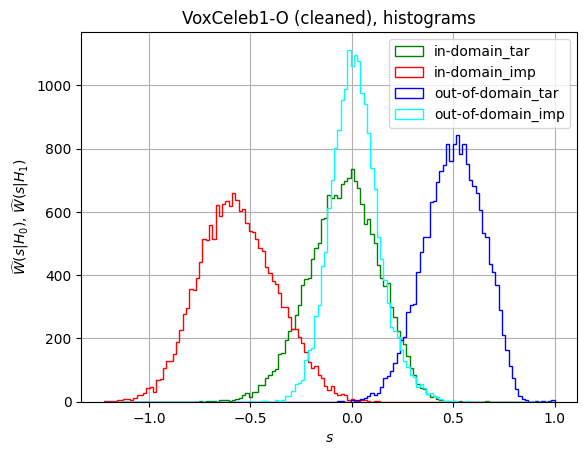

Equal Error Rate in-domain (EER): 8.340%, threshold EER: -0.284 
Equal Error Rate out-of-domain (EER): 4.051%, threshold EER: 0.242 


In [ ]:
# Perform s normalization
all_scores_in_domain, all_labels_in_domain, all_trials_in_domain = s_norm(feats_in_domain, protocol, feats_adapt, N_s=100, eps=0.6)

# Compute target and impostor histogram
plot_histograms_2sets(all_scores_in_domain, all_labels_in_domain,
                      all_scores_out_of_domain, all_labels_out_of_domain)

**5. Калибровка системы голосовой биометрии**

Результатом процедуры сравнения дикторских моделей являются «сырые» оценки сравнения. Основными проблемами при использовании «сырых» оценок являются:

1. Порог принятия решения для выбранной рабочей точки полностью привязан к системе распознавания диктора (если существует $N$ систем, то существует $N$ порогов).
2. Для произвольной выходной оценки сравнения нет информации о вероятности принадлежности к статистическим гипотезам.
3. Сложно учесть влияние параметров качества речевого сигнала на выходные оценки.

*Калибровка* является решением указанных проблем. Необходимость калибровки в сообществе по распознаванию диктора обусловлена следующим:

1. Представление оценок сравнения в калиброванном виде для конкурсов, например, NIST SRE. Качество калибровки учитывается наравне с качеством верификации.
2. В коммерческих системах распознавания по голосу, так как на практике для заданной оценки сравнения важно знать вероятность статистической гипотезы.

В простейшем случае модель калибровки для системы распознавания диктора может быть описаны в виде линейной функциональной зависимости: $S_c = aS + b$. Здесь $a$ и $b$ – это параметры линейной модели калибровки, $S$ – это «сырое» значение оценки сравнения, а $S_c$ – значение оценки сравнения после калибровки.

Для обучения параметров $a$ и $b$ линейной модели калибровки можно воспользоваться стоимостной функцией для *логистической регресии*. Можно доказать, что при решении задачи верификации апостериорная вероятность принадлежности пары сравнения «эталон-тест» к таргет-паре (нулевая гипотеза, $H_0$) для заданного значения калиброванной оценки сравнения эталона и теста может быть выражена следующим образом: $P(H_0|S_c) = \frac{1}{1 + e^{-S_c + T_{act}^{LLR}}}$. Здесь $T_{act}^{LLR}$ – это величина оптимального порога принятия решения в пространстве логарифма отношения правдоподобия. Фактически, величина $T_{act}^{LLR}$ задаёт желаемую теоретически рабочую точку биометрической системы. Обычно в научно-технической литературе по распознаванию диктора величина $T_{act}^{LLR}$ задается в следующем виде: $T_{act}^{LLR} = ln\left ( \frac{1 - P(H_0)}{P(H_0)} \right )$. Здесь $P(H_0)$ – это априорная вероятность таргет-гипотезы. Аналогичным образом, что и выше, можно записать апостериорную вероятность принадлежности пары сравнения «эталон-тест» к импостор-паре (альтернативная гипотеза, $H_1$) для заданного значения калиброванной оценки сравнения эталона и теста: $P(H_1|S_c) = \frac{1}{1 + e^{S_c - T_{act}^{LLR}}}$. Предполагая, что априорные вероятность выпадения таргет- и импостор-попыток равны $P(H_0)$ и $P(H_1)$, соответственно, можно записать следующее выражение для стоимостной функции, которая позволит путём численной оптимизации, вычислить оптимальные значения параметров $a$ и $b$ через минимизацию стоимостной функции:

$$J(a,b) = \frac{P(H_0)}{N_0}\sum_{i=1}^{N_0}ln\left ( 1 + e^{-(aS_i + b) + T_{act}^{LLR}} \right ) + \frac{1 - P(H_0)}{N_1}\sum_{i=1}^{N_1}ln\left ( 1 + e^{aS_i + b - T_{act}^{LLR}} \right ),$$

где $N_0$ и $N_1$ – это количество таргет- и импостор-пар в калибровочном протоколе для верификации, который необходимо подготовить отдельно перед обучением калибровочной модели. Попытки сравнения «эталон-тест» в калибровочном протоколе должны быть схожими с теми, что будут встречаться при практическом использовании итоговой системы распознавания диктора, в смысле длительностей эталонной и тестовой звукозаписей, условий записи фонограмм и т.п.

Для оценки качества модели калибровки системы голосовой биометрии можно воспользоваться подходом представленным ниже.

Пусть в настоящей лабораторной работе *байесовский риск* задан в следующем виде: $\overline{C} = P(D_1|H_0)P(H_0) + P(D_0|H_1)P(H_1)/P(H_0)$. Здесь $P(D_1|H_0)$ – это вероятность ошибки первого рода, а $P(D_0|H_1)$ – вероятность ошибки второго рода. Биометрическая система считается откалиброванной, если практический минимум байесовского риска, $\overline{C}_{min}$, вычисленный в эмпирически подобранном пороге $T_{min}^{LLR}$ по отношению к некоторому протоколу тестирования для задачи верификации, совпадает с теоретическим минимум байесовского риска, $\overline{C}_{act}$, вычисленным в точке $T_{act}^{LLR}$.

В рамках настоящего пункта необходимо обучить линейную модель калибровки. Для решения указанной задачи необходимо выполнить следующие действия:

1. Подготовить калибровочный протокол для обучения модели калибровки.
2. Задать рабочую точку, которая определит величину $T_{act}^{LLR}$.
3. Обучить калибровочную модель путём минимизации стоимостной функции для логистической регрессии с использованием методов численной оптимизации первого порядка.
4. Посчитать значения $\overline{C}_{min}$ и $\overline{C}_{act}$, а также $T_{min}^{LLR}$ и $T_{act}^{LLR}$ для выбранных протоколов тестирования до выполнения и после выполнения процедуры калибровки.

In [ ]:
# Select hyperparameters

# Calibration parameters
P_tar               = 0.5                                # probability of target hypothesis
calib_protocol_size = 40000                              # number of trials in calibration protocol

# Train dataloader
batch_size          = 1                                  # batch size to train
pin_memory          = True                               # pin memory
num_workers         = 1                                  # number of workers to train
shuffle             = True                               # shuffling of training examples

# Optimizer
weight_decay        = 0                                  # weight decay value
lr                  = 5                                  # learning rate value

# Scheduler
step_size           = 100                                # period of learning rate decay
gamma               = 0.1                                # multiplicative factor of learning rate decay
max_epoch           = 300                                # number of epoches

In [ ]:
# # Download meta data for calibration set datasets
# with open('../data/lists/protocols2.txt', 'r') as f:
#     lines = f.readlines()

# download_protocol(lines, save_path='../data/voxceleb2_test')

In [ ]:
setfiles = get_voxceleb_filelist(input_path='../data/voxceleb2_test/wav')
setfiles.sort()

# Define calibration data loader
calib_dataset = test_dataset_loader(setfiles, test_path='../data/voxceleb2_test/wav', eval_frames=1000, num_eval=1)
calib_loader  = torch.utils.data.DataLoader(calib_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False, sampler=None)

# Extract features for every image
feats_calib = extract_features(model, calib_loader)

/home/ext-shirokov-m@ad.speechpro.com/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Create calibration protocol
spk_ids_calib_protocol = []   # speaker IDs in calibration protocol
for key in feats_calib.keys():
    spk_ids_calib_protocol.append(key.split('/')[0])

spk_ids_calib_protocol = list(set(spk_ids_calib_protocol))

protocol_train = []           # calibration protocol

# Generate target trials
count = 0
while count < int(P_tar*calib_protocol_size):
    spk_id   = np.random.choice(spk_ids_calib_protocol, 1)[0]
    spk_utts = list(filter(lambda x: spk_id in x, feats_adapt.keys()))
    spk_utts = np.random.choice(spk_utts, 2)
    
    if spk_utts[0].split('/')[1] != spk_utts[1].split('/')[1]:
        protocol_train.append(' '.join(['1', spk_utts[0], spk_utts[1]]))
        
        count = count + 1

# Generate impostor trials
count = 0
while count < int((1 - P_tar)*calib_protocol_size):
    spk_ids  = np.random.choice(spk_ids_calib_protocol, 2)
    
    if spk_ids[0] != spk_ids[1]:
        spk1_utts = list(filter(lambda x: spk_ids[0] in x, feats_adapt.keys()))
        spk1_utts = np.random.choice(spk1_utts, 1)[0]
        spk2_utts = list(filter(lambda x: spk_ids[1] in x, feats_adapt.keys()))
        spk2_utts = np.random.choice(spk2_utts, 1)[0]
        
        protocol_train.append(' '.join(['0', spk1_utts, spk2_utts]))
        
        count = count + 1

In [ ]:
# Compute scores between enroll and test for calibration protocol
all_scores_calib_train, \
all_labels_calib_train, \
all_trials_calib_train           = compute_scores_cosine(feats_calib, protocol_train)

# Initialize train dataloader
tar_calib_train, imp_calib_train = get_tar_imp_scores(all_scores_calib_train, all_labels_calib_train)
calib_train_set                  = CalibrationDataset(target_scores=tar_calib_train, impostor_scores=imp_calib_train)
calib_train_loader               = DataLoader(calib_train_set, batch_size=1, pin_memory=pin_memory, num_workers=num_workers, shuffle=True)

Scoring progress:   1%|          | 442/40000 [00:00<00:08, 4415.00it/s]

Scoring progress: 100%|██████████| 40000/40000 [00:08<00:00, 4501.06it/s]


In [ ]:
# Initialize calibration model
calib_model = LinearCalibrationModel()
criterion = CalibrationLoss(ptar=P_tar)

# Initialize optimizer and scheduler
optimizer = SGDOptimizer(calib_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = StepLRScheduler(optimizer, test_interval=step_size, lr_decay=gamma)

# Train model
train_calibration(calib_train_loader, calib_model, criterion, optimizer, scheduler, max_epoch, verbose=True)

Initialised SGD optimizer.
Initialised step LR scheduler.


Epoch 0, LR 5.000000 Loss 0.855591
Epoch 1, LR 5.000000 Loss 0.817622
Epoch 2, LR 5.000000 Loss 0.481227
Epoch 3, LR 5.000000 Loss 0.356726
Epoch 4, LR 5.000000 Loss 0.276078
Epoch 5, LR 5.000000 Loss 0.226621
Epoch 6, LR 5.000000 Loss 0.194528
Epoch 7, LR 5.000000 Loss 0.173431
Epoch 8, LR 5.000000 Loss 0.159421
Epoch 9, LR 5.000000 Loss 0.150043
Epoch 10, LR 5.000000 Loss 0.143736
Epoch 11, LR 5.000000 Loss 0.139495
Epoch 12, LR 5.000000 Loss 0.136662
Epoch 13, LR 5.000000 Loss 0.134800
Epoch 14, LR 5.000000 Loss 0.133612
Epoch 15, LR 5.000000 Loss 0.132892
Epoch 16, LR 5.000000 Loss 0.132497
Epoch 17, LR 5.000000 Loss 0.132329
Epoch 18, LR 5.000000 Loss 0.132313
Epoch 19, LR 5.000000 Loss 0.132401
Epoch 20, LR 5.000000 Loss 0.132554
Epoch 21, LR 5.000000 Loss 0.132746
Epoch 22, LR 5.000000 Loss 0.132959
Epoch 23, LR 5.000000 Loss 0.133179
Epoch 24, LR 5.000000 Loss 0.133397
Epoch 25, LR 5.000000 Loss 0.133607
Epoch 26, LR 5.000000 Loss 0.133803
Epoch 27, LR 5.000000 Loss 0.133984
Ep

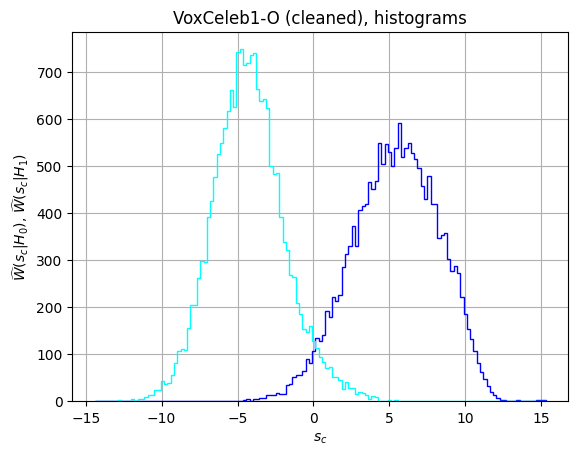

In [ ]:
# Create target and impostor raw scores
tar_test, imp_test  = get_tar_imp_scores(all_scores_out_of_domain, all_labels_out_of_domain)

# Compute target and impostor calibrated scores
calib_model.eval()

tar_test_calib = calib_model(torch.tensor([tar_test]).transpose(0, 1))
tar_test_calib = tar_test_calib.detach().numpy().squeeze()
imp_test_calib = calib_model(torch.tensor([imp_test]).transpose(0, 1))
imp_test_calib = imp_test_calib.detach().numpy().squeeze()

# Plot histograms for target and impostor scores to calibrated scores
min_scores = np.concatenate((tar_test_calib, imp_test_calib)).min()
max_scores = np.concatenate((tar_test_calib, imp_test_calib)).max()

hist(tar_test_calib, int(sqrt(len(tar_test_calib))), histtype='step', color='blue', range=(min_scores, max_scores))
hist(imp_test_calib, int(sqrt(len(imp_test_calib))), histtype='step', color='cyan',   range=(min_scores, max_scores))
xlabel('$s_c$'); ylabel('$\widehat{W}(s_c|H_0)$, $\widehat{W}(s_c|H_1)$'); title('VoxCeleb1-O (cleaned), histograms'); grid(); show()

In [ ]:
# Compute metrics before calibration
EER, _               = get_eer(tar_test, imp_test)
minDCF, _, actDCF, _ = get_dcf(tar_test, imp_test, P_target=P_tar)
print('Values of metrics before calibration')
print("EER: {0:.3f}%, minDCF: {1:.4f}, actDCF: {2:.4f}, Ptar: {3:.2f}".format(EER, minDCF, actDCF, P_tar))

Values of metrics before calibration
EER: 4.051%, minDCF: 0.0802, actDCF: 0.5403, Ptar: 0.50


In [ ]:
# Compute metrics after calibration
EER, _               = get_eer(tar_test_calib, imp_test_calib)
minDCF, _, actDCF, _ = get_dcf(tar_test_calib, imp_test_calib, P_target=P_tar)
print('Values of metrics after calibration')
print("EER: {0:.3f}%, minDCF: {1:.4f}, actDCF: {2:.4f}, Ptar: {3:.2f}".format(EER, minDCF, actDCF, P_tar))

Values of metrics after calibration
EER: 4.051%, minDCF: 0.0802, actDCF: 0.0809, Ptar: 0.50


**6. Контрольные вопросы**
											
1. Что такое доменная адаптация?
2. Как выполнить процедуру адаптации на основе s-нормализации?
3. Для какой цели решается задача калибровки?
4. Что такое «хорошая» калибровка?
5. Какие модели калибровки систем голосовой биометрии рассматриваются на практике?
6. Как обучить калибровочную модель с использованием метода логистической регресии?

**7. Список литературы**

1. Matějka P., Novotný O., Plchot O., Burget L., Sánchez M.D., Černocký J. Analysis of score normalization in multilingual speaker recognition // Proc. Interspeech 2017, 2017. P. 1567–1571 ([ссылка](https://www.isca-speech.org/archive/pdfs/interspeech_2017/matejka17_interspeech.pdf)).

2. Gusev A., Volokhov V., Vinogradova A., Andzhukaev T., Shulipa A., Novoselov S., Pekhovsky T., Kozlov A. STC-Innovation speaker recognition systems for far-field speaker verification challenge 2020 // Proc. Interspeech 2020, 2020. P. 3466–3470 ([ссылка](https://www.isca-speech.org/archive/pdfs/interspeech_2020/gusev20_interspeech.pdf)).

3. Brümmer N., Villiers E. The BOSARIS toolkit: theory, algorithms and code for surviving the new DCF // arXiv:1304.2865 [stat.AP] ([ссылка](https://arxiv.org/pdf/1304.2865.pdf)).

4. Mandasari M.I., Saeidi R., McLaren M., Leeuwen D. Quality measure functions for calibration of speaker recognition systems in various duration conditions // IEEE Trans. Audio Speech and Language Processing, 2013. V. 21. №11. P. 2425–2438 ([ссылка](https://www.researchgate.net/publication/260695687_Quality_Measure_Functions_for_Calibration_of_Speaker_Recognition_Systems_in_Various_Duration_Conditions)).